In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss, confusion_matrix, roc_curve, auc, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, BatchNormalization


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
# Load your scaled data
df_train = pd.read_csv('/content/drive/MyDrive/AI ML Project/Train_data_4M.csv')
df_val = pd.read_csv('/content/drive/MyDrive/AI ML Project/Val_data_4M')

# Prepare the datasets
X_train = df_train.drop('click', axis=1)
y_train = df_train['click']
X_val = df_val.drop('click', axis=1)
y_val = df_val['click']

Epoch 1/200
3905/3907 [============================>.] - ETA: 0s - loss: 0.4348 - accuracy: 0.8257
Epoch 1: val_accuracy improved from -inf to 0.82926, saving model to /content/drive/MyDrive/AI ML Project/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3907/3907 [==============================] - 28s 6ms/step - loss: 0.4348 - accuracy: 0.8257 - val_loss: 0.4200 - val_accuracy: 0.8293
Epoch 2/200
3900/3907 [============================>.] - ETA: 0s - loss: 0.4193 - accuracy: 0.8309
Epoch 2: val_accuracy improved from 0.82926 to 0.82980, saving model to /content/drive/MyDrive/AI ML Project/model_checkpoint.h5
3907/3907 [==============================] - 25s 6ms/step - loss: 0.4193 - accuracy: 0.8309 - val_loss: 0.4155 - val_accuracy: 0.8298
Epoch 3/200
3907/3907 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8314
Epoch 3: val_accuracy improved from 0.82980 to 0.83202, saving model to /content/drive/MyDrive/AI ML Project/model_checkpoint.h5
3907/3907 [==============================] - 24s 6ms/step - loss: 0.4165 - accuracy: 0.8314 - val_loss: 0.4127 - val_accuracy: 0.8320
Epoch 4/200
3906/3907 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8316
Epoch 4: val_accuracy improved from 0.83202

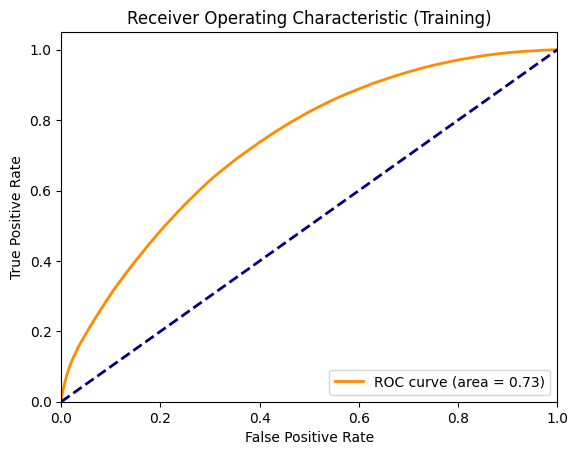

31250/31250 [==============================] - 48s 2ms/step
Performance on Validation Dataset:
Accuracy: 0.833326
Log Loss: 0.4060014570998495
F1 Score: 0.7771597941271126
Classification Report:
              precision    recall  f1-score         support
0              0.839783  0.987641  0.907731   830114.000000
1              0.567678  0.079294  0.139152   169886.000000
accuracy       0.833326  0.833326  0.833326        0.833326
macro avg      0.703731  0.533468  0.523441  1000000.000000
weighted avg   0.793556  0.833326  0.777160  1000000.000000
Confusion Matrix:
[[819855  10259]
 [156415  13471]]
Normalized Confusion Matrix:
[[0.98764146 0.01235854]
 [0.92070565 0.07929435]]


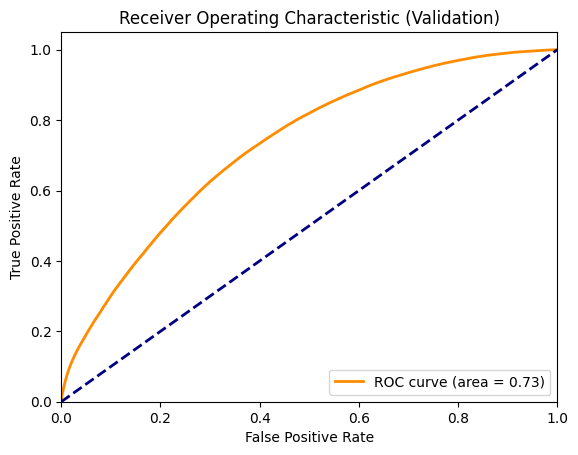

In [8]:
# Define the neural network model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/AI ML Project/model_checkpoint.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=1024,
    callbacks=[checkpoint, early_stopping]
)

# Function to calculate and print performance metrics and save classification report
def evaluate_performance(X, y, dataset_name):
    # Predict probabilities and classes
    y_pred_probs = model.predict(X)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Log Loss
    log_loss_value = log_loss(y, y_pred_probs)

    # Classification Report, F1 Score, and Saving Report
    report = classification_report(y, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'{dataset_name.lower()}_classification_report.csv')

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Accuracy
    accuracy = accuracy_score(y, y_pred)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Print Metrics
    print(f"Performance on {dataset_name} Dataset:")
    print(f"Accuracy: {accuracy}")
    print(f"Log Loss: {log_loss_value}")
    print(f"F1 Score: {f1_score}")
    print("Classification Report:")
    print(report_df)
    print("Confusion Matrix:")
    print(cm)
    print("Normalized Confusion Matrix:")
    print(cm_normalized)

    # Plot ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({dataset_name})')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate Performance on Training and Validation Datasets
evaluate_performance(X_train, y_train, "Training")
evaluate_performance(X_val, y_val, "Validation")
